In [7]:
import network_manipulation as nm
import network_stats as ns
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import networkx as nx

dataset_paths = [
'Sociopatterns datasets/conference_2009.dat_',
'Sociopatterns datasets/highschool_2011.csv',
'Sociopatterns datasets/highschool_2012.csv',
'Sociopatterns datasets/highschool_2013.csv',
'Sociopatterns datasets/hospital_2010.dat_',
'Sociopatterns datasets/primaryschool_2014.csv',
'Sociopatterns datasets/workplace_2013.dat',
'Sociopatterns datasets/workplace_2015.dat_']

dataset_names = [
    'Conference 1', 
    'Highschool 1', 
    'Highschool 2', 
    'Highschool 3', 
    'Hospital 1', 
    'Primaryschool 1', 
    'Workplace 1', 
    'Workplace 2']

Node measures
degree : 17.792048929663608
weight : 64.80165005156411
closeness : 152.51139972965692
betweenness : 1.1665691363850876
eigenvector : 16.501379789393575


Network measures
nodes : 327
edges : 5818
ratio : 17.792048929663608
components : 1
density : 0.10915367441511416
path : 2.1594341569576554
diameter : 4
transitivity : 0.44442135612150807




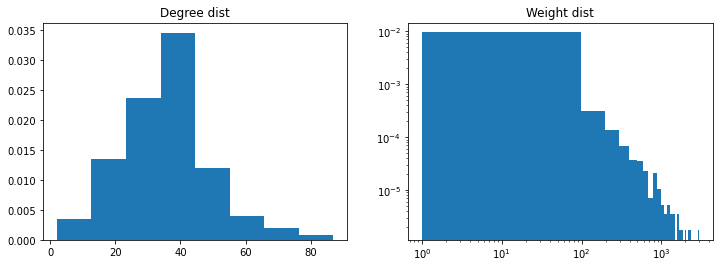

In [8]:
# Measuring original network

G = nm.build_nxgraph(dataset_paths[3], False) 
node_measures = ns.measure_nodes(G)
network_measures = ns.measure_network(G)

def print_dict(dict):
    for key in list(dict.keys()):
        print(key + ' : ' + str(dict[key]))
    print('\n')
        
print('Node measures')
print_dict(node_measures)
print('Network measures')
print_dict(network_measures)

degrees, weights = ns.analyse_graph(G)

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(12)

axis[0].hist(degrees, bins = 8, density = 1)
axis[0].set_title('Degree dist')

axis[1].hist(weights, bins = 30, density = 1)
axis[1].set_title('Weight dist')
axis[1].set_xscale('log')
axis[1].set_yscale('log')
plt.show()

# Should also include plots of degree dist and weight dist

In [9]:
# For some reason this breaks when using normalizaed weights
# While logbinning the data, it complains about ydata not being defined
# This could be because the scale is designed to be calculated for un-normalized
# weights, so could fix by making log binning function account for norming

import scipy.stats as sps

dfit, dcov = ns.fit_degrees(degrees)

class degree_distribution(sps.rv_continuous): 
    def _pdf(self, x):
        return ns.degree_func(x, *dfit)

ddist = degree_distribution(a=0)
degree_samples = ddist.rvs(size = 500) # 1000 samples, 2.5x bigger for network[0]
degree_samples = np.ceil(degree_samples).astype(int)
degree_samples = [ds for ds in degree_samples if ds != 0] # removes any zeros

print(sum(degree_samples))
if sum(degree_samples)%2 != 0:
    degree_samples = np.append(degree_samples, 35) # chose this as seems to be average from graph
print(sum(degree_samples))

H = nx.configuration_model(degree_samples, create_using = nx.Graph)

18588
18588


In [10]:
scale, scale_err = ns.optimize_scale(weights)
wfit, wcov = ns.fit_weights(weights, scale)

class weight_distribution(sps.rv_continuous): 
    def _pdf(self, x):
        return ns.weight_func(x, *wfit)

w_func = weight_distribution(a=0)



H = ns.set_weights(H, w_func)

  best scaling factor    best average error
---------------------  --------------------
                 2.89                  2.93


IndexError: list index out of range

In [ ]:
w_func = weight_distribution(a=1)
w_samples = w_func.rvs(size = 100)
print(w_samples)

[1.00002592 1.00014243 1.00009627 1.00010802 1.00009101 1.00013953
 1.00011955 1.00002708 1.00013842 1.00003784 1.00000401 1.00002588
 1.00001112 1.00006125 1.00015089 1.00014097 1.00014017 1.00011026
 1.00006823 1.00009729 1.00005411 1.00010924 1.00007388 1.00002091
 1.0001135  1.00001941 1.00010635 1.00009162 1.00004462 1.00012961
 1.00009275 1.00002601 1.00005437 1.00011023 1.00006592 1.00012601
 1.00001378 1.00001585 1.00004858 1.00011478 1.00003118 1.00003544
 1.00015216 1.00010843 1.00012022 1.0001205  1.00000886 1.00006991
 1.00015867 1.00010014 1.00000456 1.00008358 1.00006069 1.00001095
 1.00014203 1.0000765  1.00013643 1.00002574 1.0000442  1.00010793
 1.00008842 1.00003154 1.00011395 1.00002249 1.00007324 1.0000617
 1.00013664 1.00008541 1.00007148 1.00011121 1.00014877 1.00014416
 1.0000409  1.00013272 1.00003479 1.00001579 1.00004967 1.00008125
 1.00008011 1.00009548 1.0001479  1.00011912 1.00008218 1.0000934
 1.00002419 1.00002969 1.00004211 1.00004499 1.00004051 1.000158

In [ ]:
min(weights)

1

In [ ]:
node_measures = ns.measure_nodes(H)
network_measures = ns.measure_network(H)

print('Node measures')
print_dict(node_measures)
print('Network measures')
print_dict(network_measures)

gen_degrees, gen_weights = ns.analyse_graph(H) # changed variable name to stop throwing off optimize_scale function

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(12)

axis[0].hist(gen_degrees, bins = 8, density = 1)
axis[0].set_title('Degree dist')

axis[1].hist(gen_weights, bins = 30, density = 1)
axis[1].set_title('Weight dist')
axis[1].set_xscale('log')
axis[1].set_yscale('log')
plt.show()

NetworkXError: Graph is not connected.

In [ ]:
# Shows that extra components of generated graph are singular nodes (i don't know
# this is happening in the configuration model), the number of extra components
# is equal to the number of times "what the dog doin is printed" which occurs when
# the graph has nodes with no connections, meaning the degree distribution is
# generating 0's so simply need to remove these.

components = list(nx.connected_components(H))
for component in components:
    print(len(component))


493


0
1
2
3
4


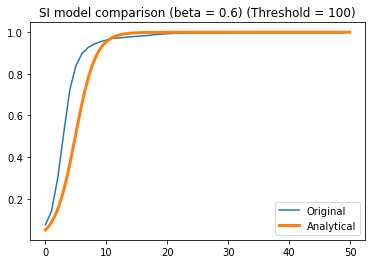

0
1
2
3
4


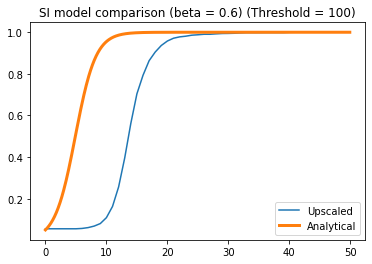

In [ ]:
import SI_model_nx as si

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.6
simulation_params['Runs'] = 5
simulation_params['Threshold'] = 100
simulation_params['Increment'] = 0.1

si.SI_comparison(G, simulation_params, 'Original')
si.SI_comparison(H, simulation_params, 'Upscaled')